# Quickstart

In this introduction we will show how to make a simple forecast using ETNA library.

In [1]:
import warnings

warnings.filterwarnings("ignore")

Let's load and prepare the data.

In [2]:
import pandas as pd

from etna.datasets import TSDataset

# Read the data
df = pd.read_csv("data/example_dataset.csv")

# Create a TSDataset
df = TSDataset.to_dataset(df)
ts = TSDataset(df, freq="D")

# Choose a horizon
HORIZON = 14

# Make train/test split
train_ts, test_ts = ts.train_test_split(test_size=HORIZON)

Define transformations and model:

In [3]:
from etna.models import CatBoostMultiSegmentModel
from etna.transforms import DateFlagsTransform
from etna.transforms import DensityOutliersTransform
from etna.transforms import FourierTransform
from etna.transforms import LagTransform
from etna.transforms import LinearTrendTransform
from etna.transforms import MeanTransform
from etna.transforms import SegmentEncoderTransform
from etna.transforms import TimeSeriesImputerTransform
from etna.transforms import TrendTransform

# Prepare transforms
transforms = [
    DensityOutliersTransform(in_column="target", distance_coef=3.0),
    TimeSeriesImputerTransform(in_column="target", strategy="forward_fill"),
    LinearTrendTransform(in_column="target"),
    TrendTransform(in_column="target", out_column="trend"),
    LagTransform(in_column="target", lags=list(range(HORIZON, 122)), out_column="target_lag"),
    DateFlagsTransform(week_number_in_month=True, out_column="date_flag"),
    FourierTransform(period=360.25, order=6, out_column="fourier"),
    SegmentEncoderTransform(),
    MeanTransform(in_column=f"target_lag_{HORIZON}", window=12, seasonality=7),
    MeanTransform(in_column=f"target_lag_{HORIZON}", window=7),
]

# Prepare model
model = CatBoostMultiSegmentModel()

Fit `Pipeline` and make a prediction:

In [4]:
from etna.pipeline import Pipeline

# Create and fit the pipeline
pipeline = Pipeline(model=model, transforms=transforms, horizon=HORIZON)
pipeline.fit(train_ts)

# Make a forecast
forecast_ts = pipeline.forecast()

Let's plot the results:

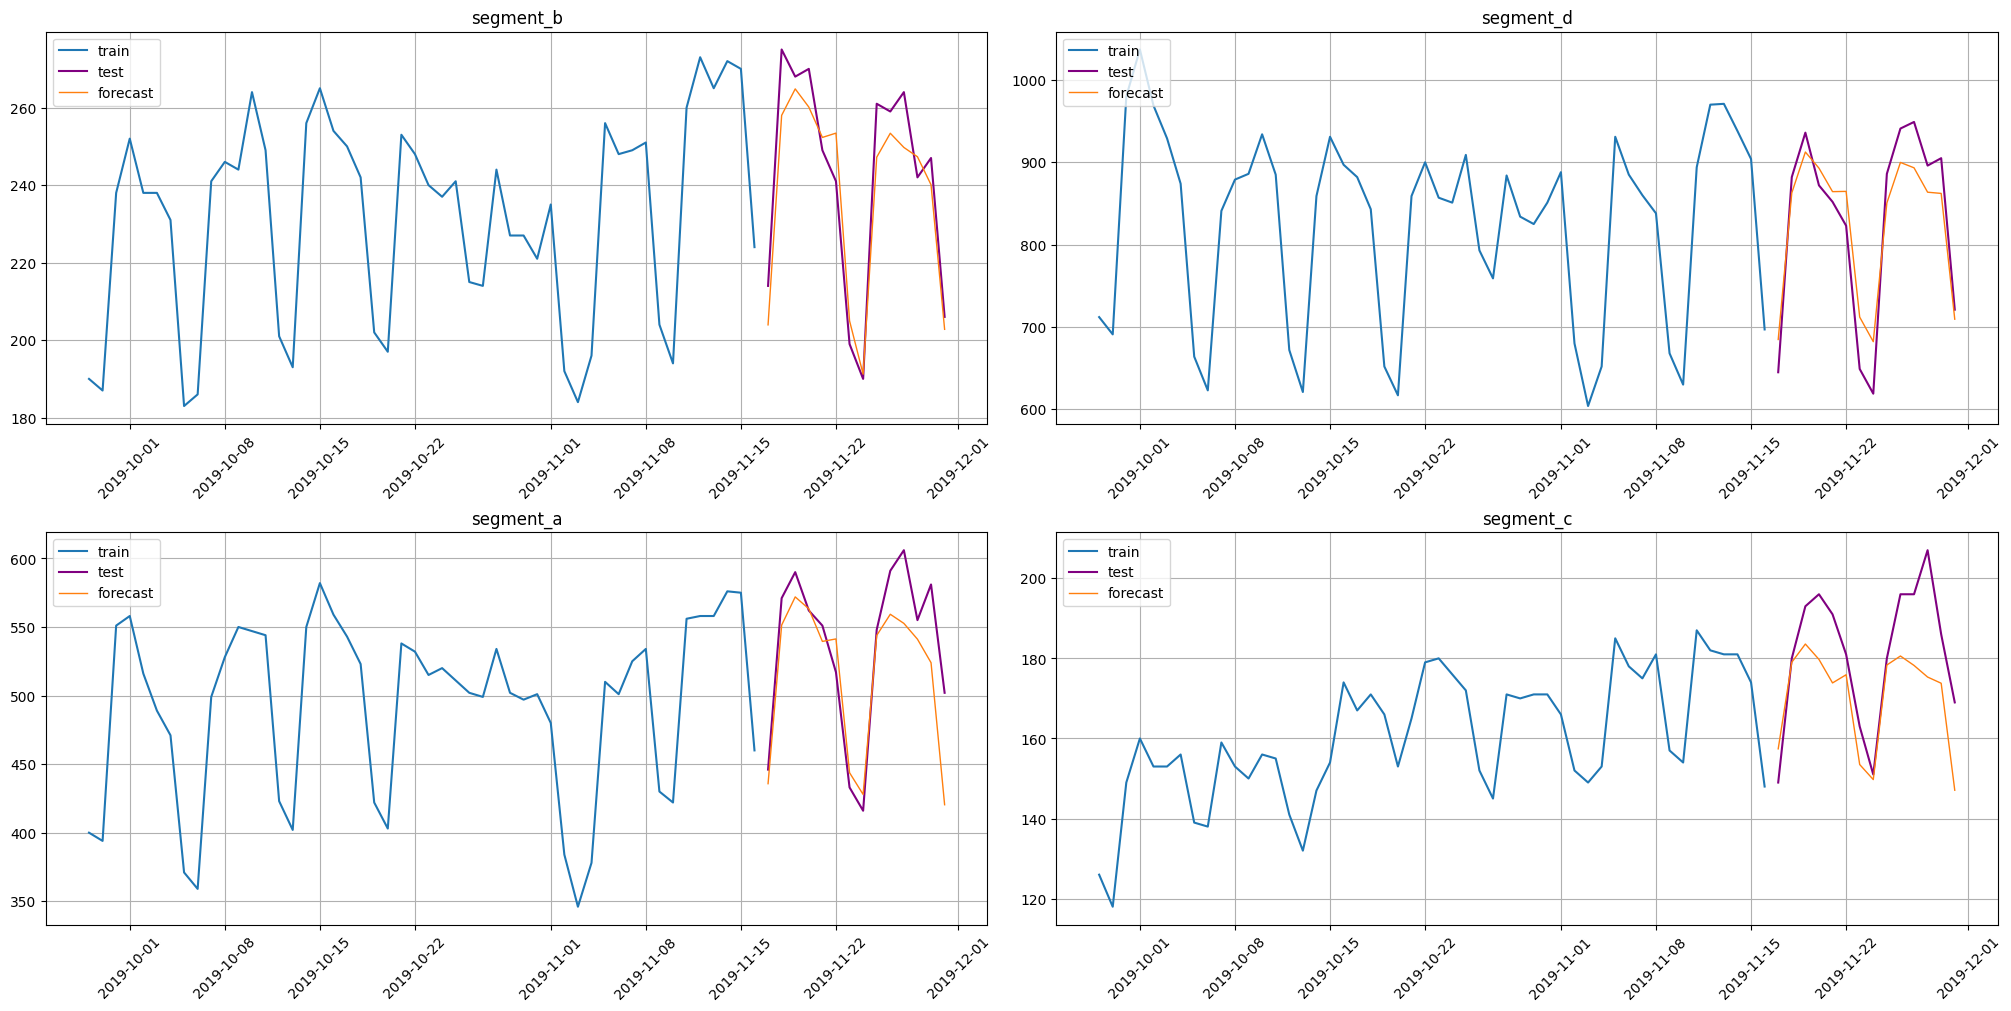

In [5]:
from etna.analysis import plot_forecast

plot_forecast(forecast_ts=forecast_ts, test_ts=test_ts, train_ts=train_ts, n_train_samples=50)

Print the metric value across the segments:

In [6]:
from etna.metrics import SMAPE

metric = SMAPE()
metric_value = metric(y_true=test_ts, y_pred=forecast_ts)
metric_value

{'segment_b': 3.271014290441896,
 'segment_d': 4.512871862697337,
 'segment_a': 4.799114474387907,
 'segment_c': 6.758606238307858}

After this short introduction you can learn more about the library in our Tutorials section.